2024-04-15 00:31:53,058 [torchrl][INFO] check_env_specs succeeded!
episode_reward_mean = 0.9972084760665894: 100%|██████████| 60000/60000 [00:16<00:00, 3598.23it/s]  


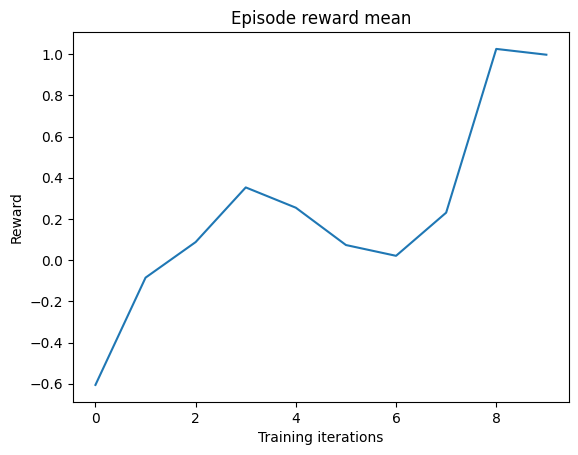

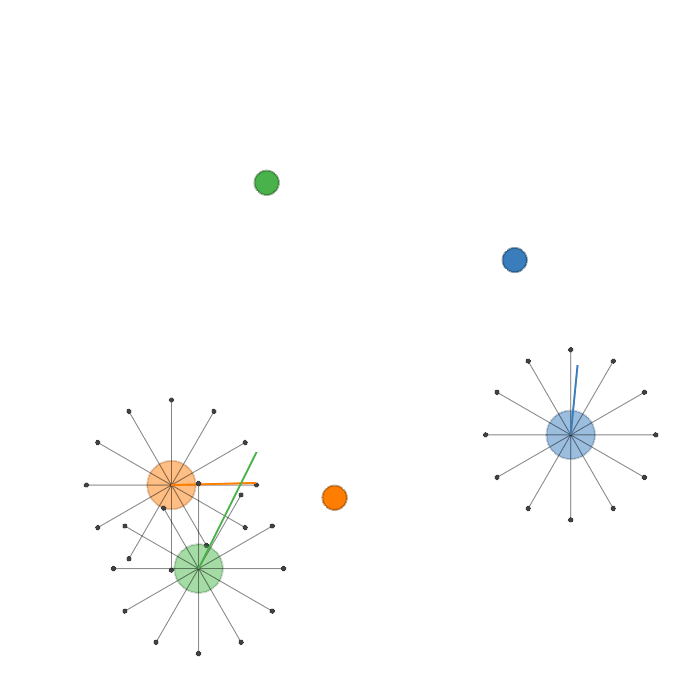

In [13]:
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
from torchrl.objectives import ClipPPOLoss, ValueEstimators
import torch.optim as optim
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import PIL.Image as PILImage
import io
import numpy as np
from IPython.display import display, Image

class PPOTrainer:
    def __init__(
        self,
        policy,
        critic,
        replay_buffer,
        optimizer,
        loss_module,
        collector,
        num_epochs,
        minibatch_size,
        frames_per_batch,
        max_grad_norm,
        device,
        total_frames,
        gamma,
        lmbda,
        clip_epsilon,
        entropy_eps,
        env,
    ):
        self.policy = policy
        self.critic = critic
        self.replay_buffer = replay_buffer
        self.optimizer = optimizer
        self.loss_module = loss_module
        self.collector = collector
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        self.frames_per_batch = frames_per_batch
        self.max_grad_norm = max_grad_norm
        self.device = device
        self.total_frames = total_frames
        self.gamma = gamma
        self.lmbda = lmbda
        self.clip_epsilon = clip_epsilon
        self.entropy_eps = entropy_eps
        self.env = env

    def train(self):
        pbar = tqdm(total=self.total_frames, desc="episode_reward_mean = 0")
        episode_reward_mean_list = []

        for tensordict_data in self.collector:
            tensordict_data.set(
                ("next", "agents", "done"),
                tensordict_data.get(("next", "done"))
                .unsqueeze(-1)
                .expand(tensordict_data.get_item_shape(("next", self.env.reward_key))),
            )
            tensordict_data.set(
                ("next", "agents", "terminated"),
                tensordict_data.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand(tensordict_data.get_item_shape(("next", self.env.reward_key))),
            )

            with torch.no_grad():
                self.loss_module.value_estimator(
                    tensordict_data,
                    params=self.loss_module.critic_network_params,
                    target_params=self.loss_module.target_critic_network_params,
                )

            data_view = tensordict_data.reshape(-1)
            self.replay_buffer.extend(data_view)

            for _ in range(self.num_epochs):
                for _ in range(self.frames_per_batch // self.minibatch_size):
                    subdata = self.replay_buffer.sample()
                    loss_vals = self.loss_module(subdata)

                    loss_value = (
                        loss_vals["loss_objective"]
                        + loss_vals["loss_critic"]
                        + loss_vals["loss_entropy"]
                    )

                    loss_value.backward()

                    torch.nn.utils.clip_grad_norm_(
                        self.loss_module.parameters(), self.max_grad_norm
                    )

                    self.optimizer.step()
                    self.optimizer.zero_grad()

            self.collector.update_policy_weights_()

            done = tensordict_data.get(("next", "agents", "done"))
            episode_reward_mean = (
                tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
            )
            episode_reward_mean_list.append(episode_reward_mean)
            pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=True)
            pbar.update(self.frames_per_batch)

        pbar.close()
        return episode_reward_mean_list


def main():
    import torch
    from tensordict.nn import TensorDictModule
    from tensordict.nn.distributions import NormalParamExtractor
    from torch import multiprocessing
    from torchrl.collectors import SyncDataCollector
    from torchrl.data.replay_buffers import ReplayBuffer
    from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
    from torchrl.data.replay_buffers.storages import LazyTensorStorage
    from torchrl.envs import RewardSum, TransformedEnv
    from torchrl.envs.libs.vmas import VmasEnv
    from torchrl.envs.utils import check_env_specs
    from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
    from torchrl.objectives import ClipPPOLoss, ValueEstimators
    from matplotlib import pyplot as plt
    from tqdm import tqdm
    import io
    import numpy as np
    from IPython.display import display, Image
    import os
    import PIL.Image as PILImage

    torch.manual_seed(0)
    is_fork = multiprocessing.get_start_method() == "fork"
    device = (
        torch.device(0)
        if torch.cuda.is_available() and not is_fork
        else torch.device("cpu")
    )
    vmas_device = device

    # Sampling
    frames_per_batch = 6_000
    n_iters = 10
    total_frames = frames_per_batch * n_iters

    # Training
    num_epochs = 1
    minibatch_size = 400
    lr = 0.0003
    max_grad_norm = 1.0

    # PPO
    clip_epsilon = 0.2
    gamma = 0.9
    lmbda = 0.9
    entropy_eps = 1e-4

    max_steps = 100
    num_vmas_envs = frames_per_batch // max_steps
    scenario_name = "navigation"
    n_agents = 3

    env = VmasEnv(
        scenario=scenario_name,
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        device=device,
        n_agents=n_agents,
    )

    env = TransformedEnv(
        env,
        RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
    )

    check_env_specs(env)

    policy_net = torch.nn.Sequential(
        MultiAgentMLP(
            n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
            n_agent_outputs=2 * env.action_spec.shape[-1],
            n_agents=env.n_agents,
            centralised=False,
            share_params=True,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        NormalParamExtractor(),
    )

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "loc"), ("agents", "scale")],
    )

    policy = ProbabilisticActor(
        module=policy_module,
        spec=env.unbatched_action_spec,
        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[env.action_key],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "min": env.unbatched_action_spec[env.action_key].space.low,
            "max": env.unbatched_action_spec[env.action_key].space.high,
        },
        return_log_prob=True,
        log_prob_key=("agents", "sample_log_prob"),
    )

    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=1,
        n_agents=env.n_agents,
        centralised=False,
        share_params=True,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    critic = TensorDictModule(
        module=critic_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "state_value")],
    )

    collector = SyncDataCollector(
        env,
        policy,
        device=vmas_device,
        storing_device=device,
        frames_per_batch=frames_per_batch,
        total_frames=total_frames,
    )

    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(frames_per_batch, device=device),
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,
    )

    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=critic,
        clip_epsilon=clip_epsilon,
        entropy_coef=entropy_eps,
        normalize_advantage=False,
    )
    loss_module.set_keys(
        reward=env.reward_key,
        action=env.action_key,
        sample_log_prob=("agents", "sample_log_prob"),
        value=("agents", "state_value"),
        done=("agents", "done"),
        terminated=("agents", "terminated"),
    )

    loss_module.make_value_estimator(
        ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
    )

    optim = torch.optim.Adam(loss_module.parameters(), lr)

    ppo_trainer = PPOTrainer(
        policy=policy,
        critic=critic,
        replay_buffer=replay_buffer,
        optimizer=optim,
        loss_module=loss_module,
        collector=collector,
        num_epochs=num_epochs,
        minibatch_size=minibatch_size,
        frames_per_batch=frames_per_batch,
        max_grad_norm=max_grad_norm,
        device=device,
        total_frames=total_frames,
        gamma=gamma,
        lmbda=lmbda,
        clip_epsilon=clip_epsilon,
        entropy_eps=entropy_eps,
        env=env,
    )

    episode_reward_mean_list = ppo_trainer.train()

    plt.plot(episode_reward_mean_list)
    plt.xlabel("Training iterations")
    plt.ylabel("Reward")
    plt.title("Episode reward mean")
    plt.show()

    env.frames = []

    def rendering_callback(env, td):
        frame = env.render(mode="rgb_array")
        env.frames.append(frame)

    with torch.no_grad():
        env.rollout(
            max_steps=max_steps,
            policy=policy,
            callback=rendering_callback,
            auto_cast_to_device=True,
            break_when_any_done=False,
        )

    env.frames = [PILImage.fromarray(frame) if isinstance(frame, np.ndarray) else frame for frame in env.frames]

    gif_path = f"{scenario_name}.gif"
    frames = env.frames
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=300,
        loop=0,
    )

    display(Image(gif_path))


if __name__ == "__main__":
    main()

